# Main working file

In [1]:
# imports

## system
import glob
import os
import numpy as np
import pandas as pd


import util.feature_extraction as fe
import util.feature_selection as fs
import util.correlation_measure as cm
import util.video_transformation as vt

from scipy.stats import pearsonr


LOCATION = "data"
ACTION_UNITS = "au"
FEATURE_FOLDER = "features"
CORRELATION_FOLDER = 'correlations'
PHASES = [f'{name}_{i}' for name, num in  [("instructional_video", 1), ("discussion_phase", 2)] for i in range(num)]#, ("reschu_run", 8)] for i in range(num)]
SETS = ['corrca', 'factors']
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

for pair in os.listdir(LOCATION):
    filename = os.path.join(LOCATION, pair, FEATURE_FOLDER)
    os.makedirs(filename, exist_ok=True)
    filename = os.path.join(LOCATION, pair, CORRELATION_FOLDER)
    os.makedirs(filename, exist_ok=True)


# Feature selection


## Facial factors

In [8]:
## EXTRACTING FACIAL FACTORS FOR EACH FILE SEPARATELY
for pair in os.listdir(LOCATION):
    if pair in ['07_08', '09_10']:
        for file in os.listdir(os.path.join(LOCATION, pair, ACTION_UNITS)):
            if ".csv" in file and 'Data' not in file: 
                filename = os.path.join(LOCATION, pair, ACTION_UNITS, file)
                participant, _ = file.split("_",1)
                df = pd.read_csv(filename)
                for name in PHASES:
                    if name in file:
                        factors = fs.au_to_factors(df)
                        factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"{participant}_{name}_factors.csv"), index=False)

## Correlated Component Analysis

In [9]:
## CREATING WEIGHTS FOR EACH PAIR SEPARATELY

# corrCA takes a df as input. This df should be all files for a pair. 
for pair in os.listdir(LOCATION):
    if pair in ['07_08', '09_10']:
        filename = os.path.join(LOCATION, pair)
        data = {}
        nav, pil = pair.split("_")
        nav_df = pd.DataFrame()
        pil_df = pd.DataFrame()
        # add all phases to a single dataframe
        for file in os.listdir(os.path.join(filename, ACTION_UNITS)):
            if ".csv" in file and 'Data' not in file: 
                df = pd.read_csv(os.path.join(filename, ACTION_UNITS, file))
                if ".csv" in file and nav in file:
                    nav_df = pd.concat([nav_df, df])
                if ".csv" in file and pil in file:
                    pil_df = pd.concat([pil_df, df])
        nav_df, pil_df = fs.make_equal_length(pair, nav_df, pil_df)
        # Ensure DataFrames are aligned and have the same length
        mask = (nav_df.isna().any(axis=1).values) | (pil_df.isna().any(axis=1).values)
        nav_df = nav_df[~mask].reset_index(drop=True)
        pil_df = pil_df[~mask].reset_index(drop=True)

        w = fs.corrCA_weights(nav_df, pil_df, number_of_components=3) #output = pair/pair_corrca_weights.csv
        w.to_csv(os.path.join(filename, f"{pair}_corrca_weights.csv"), index=False)


files of pairs in 07_08 do not have the same amount of datapoints - temporary fix has made them equal length
(17, 17)
files of pairs in 09_10 do not have the same amount of datapoints - temporary fix has made them equal length
(17, 17)


In [10]:
## APPLYING CORRCA WEIGHTS TO EACH FILE SEPARATELY

for pair in os.listdir(LOCATION):
    loc = os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')
    if not os.path.exists(loc):
        break
    w = pd.read_csv(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv'))
    for file in os.listdir(os.path.join(LOCATION, pair, ACTION_UNITS)):
        if ".csv" in file and 'Data' not in file:  
            filename = os.path.join(LOCATION, pair, ACTION_UNITS, file)
            participant, _ = file.split("_", 1)
            df = pd.read_csv(filename)
            for name in PHASES:
                if name in file:
                    corrca = fs.apply_corrCA_weights(df, w)
                    corrca.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"{participant}_{name}_corrca.csv"), index=False)
                    continue


# Correlation measure: cRQA

In [3]:
# TODO: cRQA at different time lags for everything
# TODO: RR at diag 0 for synchrony
# TODO: RR max lag for mimicry

# EXPERIMENT AREA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_corrca.csv'))
pil = pd.read_csv(os.path.join(files1, 'pp08_reschu_run_1_corrca.csv'))


Downsampling from 18838 to 3140 points
Radius: 1.0000, Current RR: 0.9666
Radius: 0.5050, Current RR: 0.4561
Radius: 0.2575, Current RR: 0.1904
Radius: 0.1338, Current RR: 0.0955
Radius: 0.0719, Current RR: 0.0500
Final radius: 0.0719
Max RR: 0.0582
Min RR: 0.0425


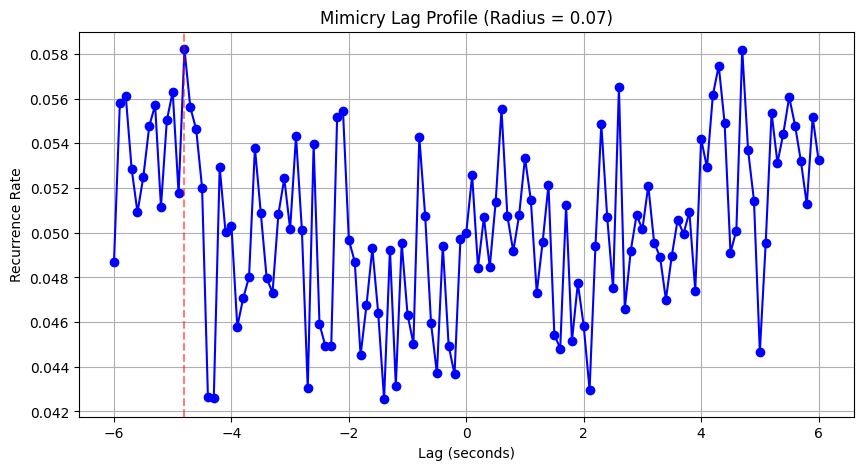

In [10]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_corrca.csv'))
pil = pd.read_csv(os.path.join(files1, 'pp08_reschu_run_1_corrca.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, normalize=False, debug=True)


Downsampling from 18838 to 3140 points
Radius: 1.0000, Current RR: 0.1264
Radius: 0.5050, Current RR: 0.0430
Final radius: 0.5050
Max RR: 0.0507
Min RR: 0.0375


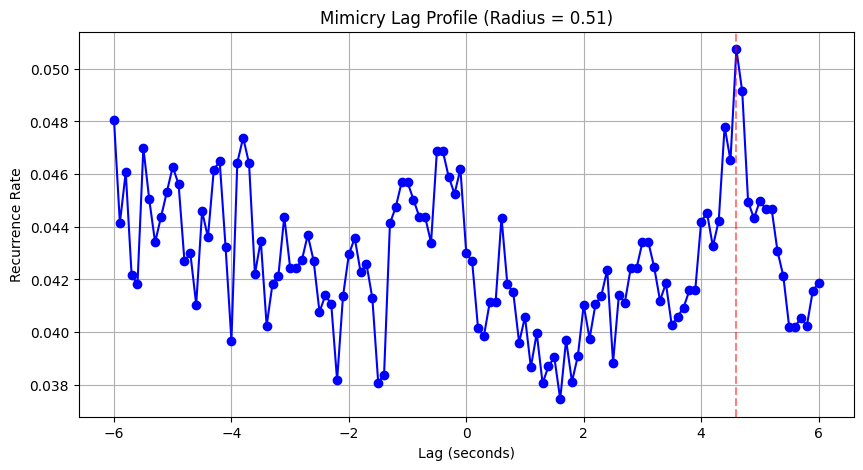

In [11]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_factors.csv'))
pil = pd.read_csv(os.path.join(files1, 'pp08_reschu_run_1_factors.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, normalize=False, debug=True)



Downsampling from 18838 to 3140 points
Radius: 1.0000, Current RR: 0.9287
Radius: 0.5050, Current RR: 0.8255
Radius: 0.2575, Current RR: 0.6280
Radius: 0.1338, Current RR: 0.4506
Radius: 0.0719, Current RR: 0.3424
Radius: 0.0409, Current RR: 0.2685
Radius: 0.0255, Current RR: 0.2131
Radius: 0.0177, Current RR: 0.1825
Radius: 0.0139, Current RR: 0.1825
Radius: 0.0119, Current RR: 0.1825
Radius: 0.0110, Current RR: 0.1825
Radius: 0.0105, Current RR: 0.1825
Radius: 0.0102, Current RR: 0.1825
Radius: 0.0101, Current RR: 0.1825
Radius: 0.0101, Current RR: 0.1825
Radius: 0.0100, Current RR: 0.1825
Radius: 0.0100, Current RR: 0.1825
Radius: 0.0100, Current RR: 0.1825
Radius: 0.0100, Current RR: 0.1825
Radius: 0.0100, Current RR: 0.1825
Final radius: 0.0100
Max RR: 0.1946
Min RR: 0.1707


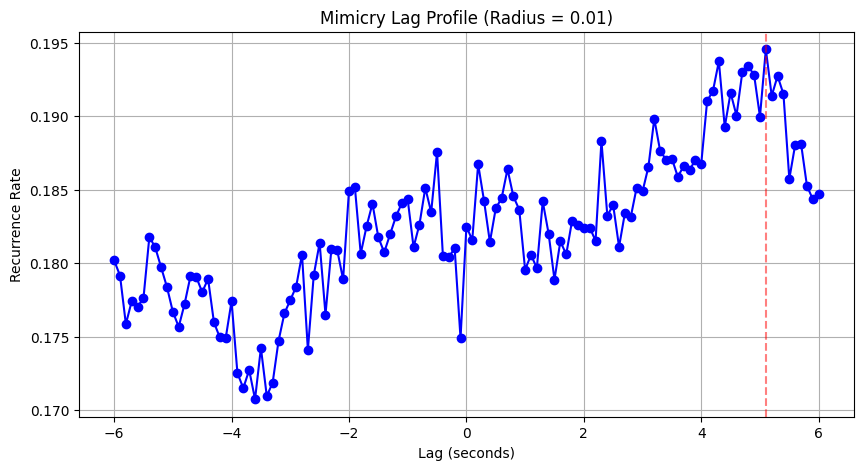

In [9]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_factors.csv'))
pil = pd.read_csv(os.path.join(files2, 'pp10_reschu_run_1_factors.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, normalize=False, debug=True)


Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-5.44, 2.37]
Normalized ranges - P2: [-10.46, 1.48]
Radius: 1.0000, Current RR: 0.6761
Radius: 0.5050, Current RR: 0.3981
Radius: 0.2575, Current RR: 0.2137
Radius: 0.1338, Current RR: 0.1159
Radius: 0.0719, Current RR: 0.0646
Radius: 0.0409, Current RR: 0.0376
Radius: 0.0564, Current RR: 0.0500
Final radius: 0.0564
Max RR: 0.0633
Min RR: 0.0390


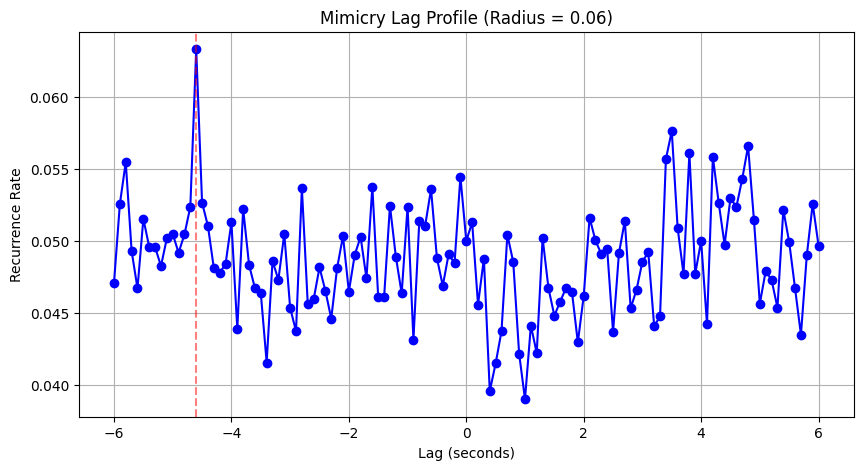

In [4]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_corrca.csv'))
pil = pd.read_csv(os.path.join(files2, 'pp10_reschu_run_1_corrca.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)

# Plot results
